In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from itertools import groupby
from imageio import imread
from random import randint
from tqdm import tqdm_notebook
from glob import glob
import keras
from keras.models import Model
from keras.layers import Conv2D, MaxPooling2D, Input, Conv2DTranspose, Concatenate, BatchNormalization, UpSampling2D
from keras.layers import  Dropout, Activation
from IPython.display import SVG

from keras.layers.advanced_activations import LeakyReLU
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras import backend as K
# from keras.utils import plot_model
import tensorflow as tf
import glob
import random
import cv2
from random import shuffle

In [ ]:
#Unzip File (zip) - Link ke google drive
import zipfile
from google.colab import drive

drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
zip_ref = zipfile.ZipFile("/content/drive/My Drive/archive.zip", 'r')
zip_ref.extractall("/content/")
zip_ref.close()

In [ ]:
print(os.listdir("/content/PneumothoraxData128/"))

['train_imges', 'train_masks', 'test_images']


In [ ]:
TRAIN_SEED = randint(1, 1000)
VALIDATION_SEED = randint(1, 1000)

In [ ]:
print(TRAIN_SEED)

424


In [ ]:
train_image_data_generator = ImageDataGenerator(
    width_shift_range = 0.1,
    height_shift_range = 0.1,
    rotation_range = 5,
    zoom_range = 0.1,
    rescale = 1.0 / 255.0
).flow_from_directory(
    "/content/PneumothoraxData128/train_imges",
    target_size = (128, 128),
    color_mode = 'grayscale',
    batch_size = 16,
    seed = TRAIN_SEED
)

train_mask_data_generator = ImageDataGenerator(
    width_shift_range = 0.1,
    height_shift_range = 0.1,
    rotation_range = 5,
    zoom_range = 0.1,
    rescale = 1.0 / 255.0
).flow_from_directory(
    "/content/PneumothoraxData128/train_masks",
    target_size = (128, 128),
    color_mode = 'grayscale',
    batch_size = 16,
    seed = TRAIN_SEED
)

validation_image_data_generator = ImageDataGenerator(rescale = 1.0 / 255.0).flow_from_directory(
    "/content/PneumothoraxData128/train_imges",
    target_size = (128, 128),
    color_mode = 'grayscale',
    batch_size = 16,
    seed = VALIDATION_SEED,
)

validation_mask_data_generator = ImageDataGenerator(rescale = 1.0 / 255.0).flow_from_directory(
    "/content/PneumothoraxData128//train_masks",
    target_size = (128, 128),
    color_mode = 'grayscale',
    batch_size = 16,
    seed = VALIDATION_SEED,
)

Found 10712 images belonging to 1 classes.
Found 10712 images belonging to 1 classes.
Found 10712 images belonging to 1 classes.
Found 10712 images belonging to 1 classes.


In [ ]:
def mask_to_rle(img, width, height):
    rle = []
    lastColor = 0
    currentPixel = 0
    runStart = -1
    runLength = 0

    for x in range(width):
        for y in range(height):
            currentColor = img[x][y]
            if currentColor != lastColor:
                if currentColor == 1:
                    runStart = currentPixel
                    runLength = 1
                else:
                    rle.append(str(runStart))
                    rle.append(str(runLength))
                    runStart = -1
                    runLength = 0
                    currentPixel = 0
            elif runStart > -1:
                runLength += 1
            lastColor = currentColor
            currentPixel+=1
    return " " + " ".join(rle)

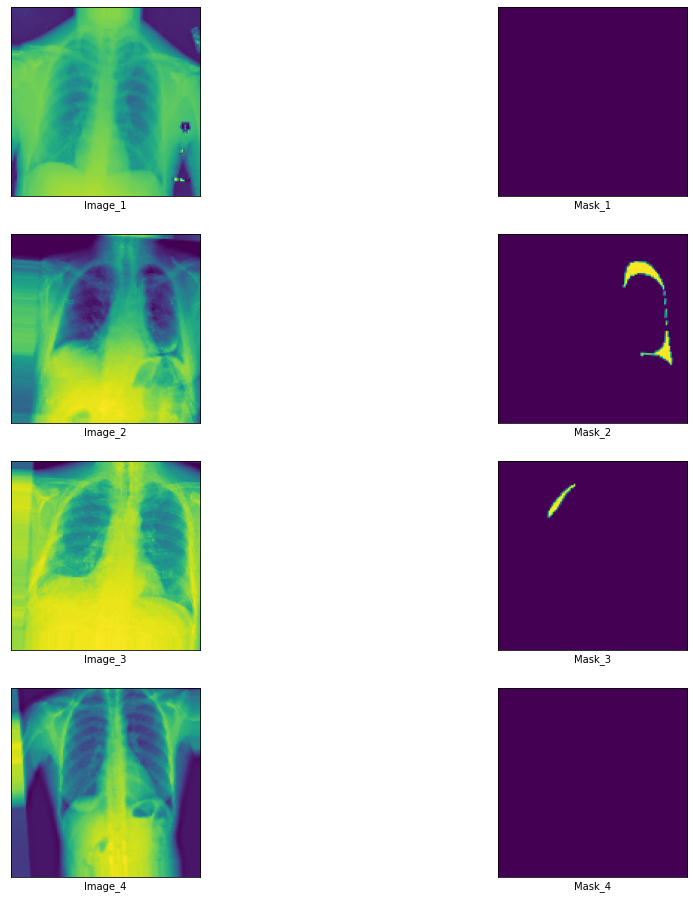

In [ ]:
x_batch, _ = train_image_data_generator.next()
y_batch, _ = train_mask_data_generator.next()
fig, axes = plt.subplots(nrows = 4, ncols = 2, figsize = (16, 16))
plt.setp(axes.flat, xticks = [], yticks = [])
c = 1
for i, ax in enumerate(axes.flat):
    if i % 2 == 0:
        ax.imshow(x_batch[c].reshape(128, 128))
        ax.set_xlabel('Image_' + str(c))
    else:
        ax.imshow(y_batch[c].reshape(128, 128))
        ax.set_xlabel('Mask_' + str(c))
        c += 1
plt.show()

In [ ]:
def mean_iou(y_true, y_pred):
    yt0 = y_true[:,:,:,0]
    yp0 = K.cast(y_pred[:,:,:,0] > 0.5, 'float32')
    inter = tf.math.count_nonzero(tf.logical_and(tf.equal(yt0, 1), tf.equal(yp0, 1)))
    union = tf.math.count_nonzero(tf.add(yt0, yp0))
    iou = tf.where(tf.equal(union, 0), 1., tf.cast(inter/union, 'float32'))
    return iou

In [ ]:
def build_unet(shape):
    input_layer = Input(shape = shape)
    #Downsampling
    conv1 = Conv2D(32, (3, 3), activation = 'relu', padding = 'same')(input_layer)
    conv1 = Conv2D(32, (3, 3), activation = 'relu', padding = 'same')(conv1)
    pool1 = MaxPooling2D(pool_size = (2, 2))(conv1)

    conv2 = Conv2D(64, (3, 3), activation = 'relu', padding = 'same')(pool1)
    conv2 = Conv2D(64, (3, 3), activation = 'relu', padding = 'same')(conv2)
    pool2 = MaxPooling2D(pool_size = (2, 2))(conv2)

    conv3 = Conv2D(128, (3, 3), activation = 'relu', padding = 'same')(pool2)
    conv3 = Conv2D(128, (3, 3), activation = 'relu', padding = 'same')(conv3)
    pool3 = MaxPooling2D(pool_size = (2, 2))(conv3)

    conv4 = Conv2D(256, (3, 3), activation = 'relu', padding = 'same')(pool3)
    conv4 = Conv2D(256, (3, 3), activation = 'relu', padding = 'same')(conv4)
    pool4 = MaxPooling2D(pool_size = (2, 2))(conv4)

    conv5 = Conv2D(512, (3, 3), activation = 'relu', padding = 'same')(pool4)
    conv5 = Conv2D(512, (3, 3), activation = 'relu', padding = 'same')(conv5)

    #Upsampling
    up6 = concatenate([Conv2DTranspose(256, (2, 2), strides = (2, 2), padding = 'same')(conv5), conv4], axis = 3)
    conv6 = Conv2D(256, (3, 3), activation = 'relu', padding = 'same')(up6)
    conv6 = Conv2D(256, (3, 3), activation = 'relu', padding = 'same')(conv6)

    up7 = concatenate([Conv2DTranspose(128, (2, 2), strides = (2, 2), padding = 'same')(conv6), conv3], axis = 3)
    conv7 = Conv2D(128, (3, 3), activation = 'relu', padding = 'same')(up7)
    conv7 = Conv2D(128, (3, 3), activation = 'relu', padding = 'same')(conv7)

    up8 = concatenate([Conv2DTranspose(64, (2, 2), strides = (2, 2), padding = 'same')(conv7), conv2], axis = 3)
    conv8 = Conv2D(64, (3, 3), activation = 'relu', padding = 'same')(up8)
    conv8 = Conv2D(64, (3, 3), activation = 'relu', padding = 'same')(conv8)

    up9 = concatenate([Conv2DTranspose(32, (2, 2), strides = (2, 2), padding = 'same')(conv8), conv1], axis = 3)
    conv9 = Conv2D(32, (3, 3), activation = 'relu', padding = 'same')(up9)
    conv9 = Conv2D(32, (3, 3), activation = 'relu', padding = 'same')(conv9)

    conv10 = Conv2D(1, (1, 1), activation = 'sigmoid')(conv9)

    return Model(input_layer, conv10)


In [ ]:
model = build_unet((128, 128, 1))
model.summary()
model.compile(optimizer = Adam(lr = 1e-5), loss = 'binary_crossentropy', metrics = [mean_iou])

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_107 (Conv2D)            (None, 128, 128, 32  320         ['input_6[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_108 (Conv2D)            (None, 128, 128, 32  9248        ['conv2d_107[0][0]']             
                                )                                                           

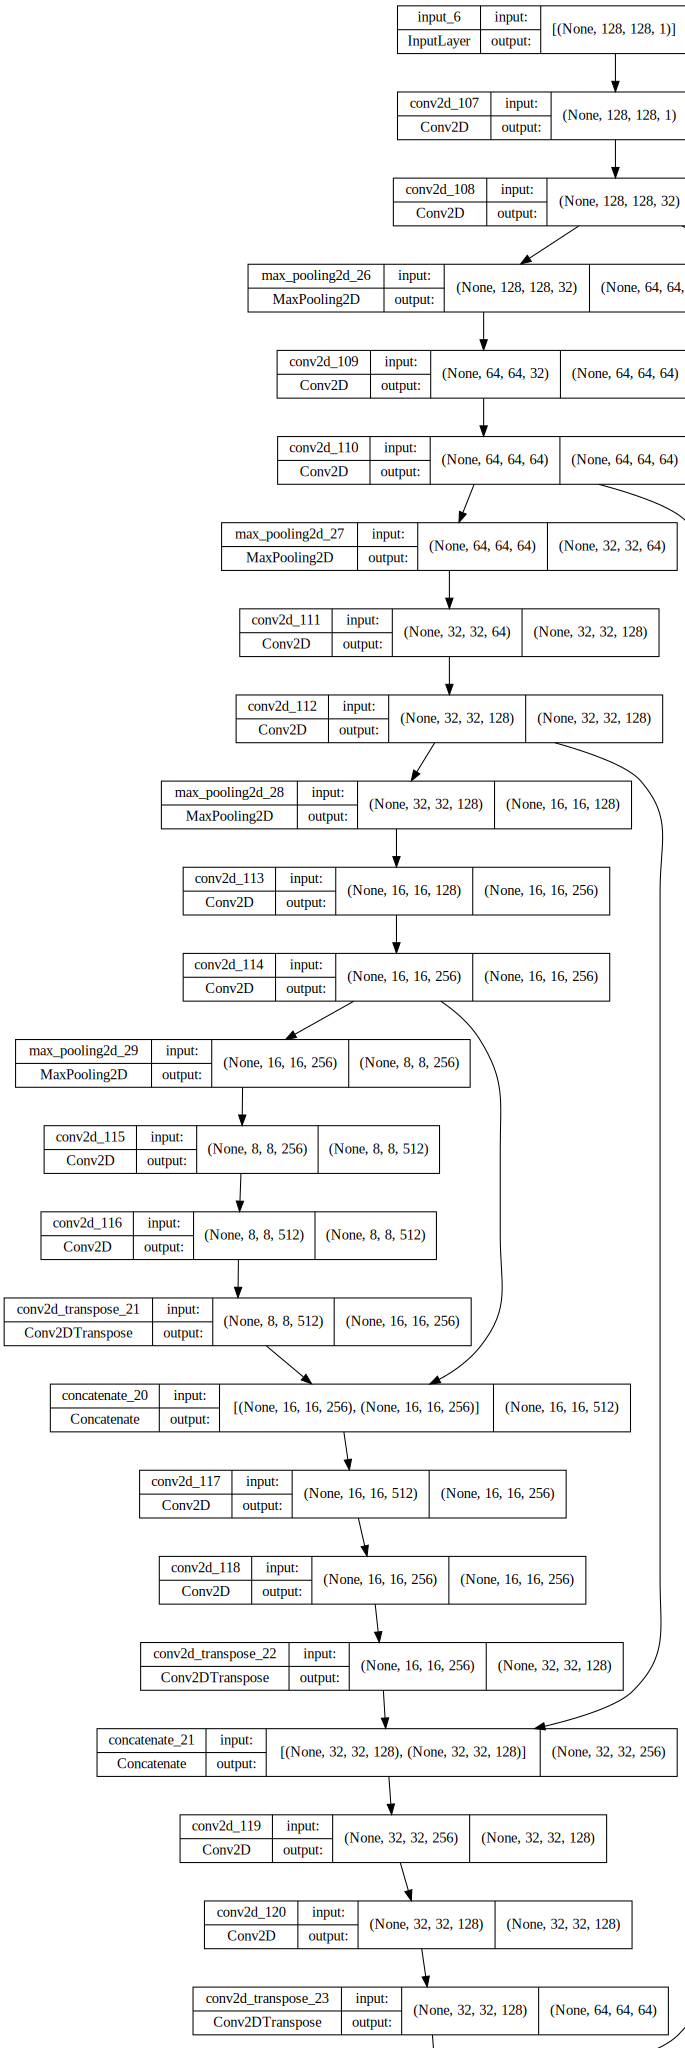

In [ ]:
SVG(model_to_dot(model, show_shapes = True, show_layer_names = True).create(prog = 'dot', format = 'svg'))

In [ ]:
weight_saver = ModelCheckpoint(
    'model.h5',
    monitor = 'mean_iou',
    save_best_only = True,
    mode = 'min',
    save_weights_only = True
)

reduce_lr_on_plateau = ReduceLROnPlateau(
    monitor = 'val_loss', factor = 0.5,
    patience = 3, verbose = 1,
    mode = 'min', min_delta = 0.0001,
    cooldown = 2, min_lr = 1e-6
)

early = EarlyStopping(
    monitor = "val_loss",
    mode = "min",
    patience = 15
)

In [ ]:
def train_data_generator(image_generator, mask_generator):
    while True:
        x_batch, _ = train_image_data_generator.next()
        y_batch, _ = train_mask_data_generator.next()
        yield x_batch, y_batch

def validation_data_generator(image_generator, mask_generator):
    while True:
        x_batch, _ = validation_image_data_generator.next()
        y_batch, _ = validation_mask_data_generator.next()
        yield x_batch, y_batch

In [ ]:
history = model.fit_generator(
    train_data_generator(
        train_image_data_generator,
        train_mask_data_generator
    ),
    epochs = 100,
    steps_per_epoch = 670,
    validation_steps = 670,
    validation_data = validation_data_generator(
        validation_image_data_generator,
        validation_mask_data_generator
    ),
    verbose = 1,
    callbacks = [
        weight_saver,
        early,
        reduce_lr_on_plateau
    ]
)

Epoch 1/100


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


670/670 [==============================] - 80s 114ms/step - loss: 0.1643 - mean_iou: 0.0076 - val_loss: 0.0212 - val_mean_iou: 0.0164 - lr: 1.0000e-05
Epoch 2/100
670/670 [==============================] - 73s 108ms/step - loss: 0.0202 - mean_iou: 0.0254 - val_loss: 0.0194 - val_mean_iou: 0.0179 - lr: 1.0000e-05
Epoch 3/100
670/670 [==============================] - 73s 108ms/step - loss: 0.0194 - mean_iou: 0.0179 - val_loss: 0.0189 - val_mean_iou: 0.0134 - lr: 1.0000e-05
Epoch 4/100
670/670 [==============================] - 72s 108ms/step - loss: 0.0192 - mean_iou: 0.0209 - val_loss: 0.0188 - val_mean_iou: 0.0194 - lr: 1.0000e-05
Epoch 5/100
670/670 [==============================] - 73s 108ms/step - loss: 0.0190 - mean_iou: 0.0254 - val_loss: 0.0185 - val_mean_iou: 0.0149 - lr: 1.0000e-05
Epoch 6/100
670/670 [==============================] - 72s 108ms/step - loss: 0.0188 - mean_iou: 0.0194 - val_loss: 0.0191 - val_mean_iou: 0.0149 - lr: 1.0000e-05
Epoch 7/100
670/670 [=============